<a href="https://colab.research.google.com/github/Irinoise/gradient-descent-implementation/blob/main/Gradient_Descent_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация градиентного спуска

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearReg(BaseEstimator):
    def __init__(self, gd_type='full',
                 tolerance=1e-6, max_iter=10000, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w = None
        self.eta = eta
        self.loss_history = None

    def fit(self, features, target):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        w_new = []
        i = 0

        if self.gd_type == 'stochastic':
            X_len = features.shape[0]- 1
            index = np.random.randint(X_len)
            X = features[index: index+1]
            y = target[index: index+1]
        elif self.gd_type == 'full':
            X = features
            y = target

        self.w = np.zeros(X.shape[1])
        self.loss_history.append(self.calc_loss(X, y))

        while True:
            gradient = self.calc_gradient(X, y)
            w_new = self.w - (self.eta * gradient)
            if np.linalg.norm(w_new - self.w) < self.tolerance:
                print('weights distance < tolerance')
                break

            self.w = w_new
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            print(
                f"iter = {i};"
                f"loss = {loss}"
                )

            i += 1
            if self.gd_type == 'stochastic':
                index = np.random.randint(X_len)
                X = features[index: index+1]
                y = target[index: index+1]

            if i > self.max_iter:
                print('max iter reached')
                break
        return self

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        else:
            y_pred = X.dot(self.w)
            return y_pred

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        # grad = 2Xt(Xw-y)
        n = X.shape[0]
        e = X.dot(self.w) - y
        grad = np.dot(np.transpose(X), e)
        return 2/n * grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        y_predicted = self.predict(X)
        mse = np.mean((y - y_predicted)**2)
        return mse

* Загрузим данные;
* Разобьем выборку на обучающую и тестовую в отношении 7:3 с random_seed=0;

In [ ]:
import pandas as pd

!wget -O 'dataset_hw2.csv' -q 'https://www.dropbox.com/s/jh3n0d05vi7azzk/export_dataframe.csv?dl=0'

data = pd.read_csv('dataset_hw2.csv')
data

,day_of_week,month,day_of_year,hour,is_abnormal_january,is_abnormal_may,log_haversine,pickup_la_guardia,dropoff_la_guardia,pickup_john_f_kennedy,dropoff_john_f_kennedy,is_traffic_jam,is_free_road,passenger_count,log_trip_duration
0,6,3,87,0,0,0,1.524717,0,0,0,0,0,0,3,7.134891
1,4,3,78,20,0,0,1.753154,0,0,0,0,0,0,1,6.878326
2,4,4,106,18,0,0,2.352776,0,1,0,0,0,0,2,7.642524
3,3,3,84,14,0,0,1.057223,0,0,0,0,0,0,1,6.888572
4,3,4,119,13,0,0,0.521534,0,0,0,0,0,0,1,6.177944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455095,5,1,9,23,0,0,1.014222,0,0,0,0,0,0,4,7.152269
1455096,3,6,154,15,0,0,0.940251,0,0,0,0,0,0,1,6.940222
1455097,0,5,123,9,0,0,0.879760,0,0,0,0,0,0,1,7.003974
1455098,2,4,97,9,0,0,1.621334,0,0,0,0,1,0,1,7.619724


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

y = data['log_trip_duration']
X = data.drop(columns=['log_trip_duration'])

categorical = ['day_of_week', 'month', 'day_of_year', 'hour', 'passenger_count', 'is_abnormal_january', 'is_abnormal_may', 'is_traffic_jam', 'is_free_road', 'pickup_la_guardia', 'dropoff_la_guardia', 'pickup_john_f_kennedy', 'dropoff_john_f_kennedy']
numeric = ['log_haversine']

scaler = StandardScaler()
one_hot_enc = OneHotEncoder(handle_unknown='ignore')

scaled_columns = scaler.fit_transform(X[numeric])
encoded_columns = one_hot_enc.fit_transform(X[categorical]).toarray()

X_fin = np.concatenate([scaled_columns, encoded_columns], axis=1)

# Добавим в X столбец с единицами, чтобы упростить вычисления в матричном виде
X_fin = np.column_stack([np.ones([X_fin.shape[0], 1], dtype=np.int32), X_fin])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size=0.3, random_state=0)

**Комментарий:**  

Значения метрик MSE для стохастического градиентного спуска в среднем несколько хуже, чем для полного градиентного спуска.

**Полный градиентный спуск** с параметрами `max_iter` = 10000 и `eta` = 1e-2 показал следующие результаты: MSE = 0.2249

**Стохастический градиентный спуск** с теми же параметрами показал следующие результаты на 10 запусках:

1) MSE = 0.2361

2) MSE = 0.2572

3) MSE = 0.2619

4) MSE = 0.2401

5) MSE = 0.2442

6) MSE = 0.2636

7) MSE = 0.2795

8) MSE = 0.2670

9) MSE = 0.2488

10) MSE = 0.2612

Влияние параметров `max_iter` и `eta` согласуется с ожиданиями. Так, количество итераций влияет на число шагов, которые делаются по антиградиенту. Таким образом, если не выполняется условие останова по разнице весов, то большее значение `max_iter` приведет в результате к меньшему значению функции потерь при одинаковых `eta`. Learning rate (`eta`) в свою очередь влияет на величину спуска на каждой итерации. Так, большее значение `eta` приводит к большему спуску на шаге –> значение функции потерь будет уменьшаться на бОльшую величину (при большом значении `eta` есть шанс перескочить минимум функции).

Для примера градиентный спуск запускался на двух значениях `eta = 1e-2` и `eta = 1e-1`.

Получены такие значения MSE на соответствующих шагах (с точностью до 4-х знаков после запятой):

При `eta = 1e-2`:

`iter` = 100: **0.3031**, `iter` = 200: **0.2677**, `iter` = 500: **0.2441**, `iter` = 1000: **0.2358**, `iter` = 5000: **0.2662**, `iter` = 10000: **0.2245**

При `eta = 1e-1`:

`iter` = 100: **0.2357**, `iter` = 200: **0.2304**, `iter` = 500: **0.2262**, `iter` = 1000: **0.2245**, `iter` = 5000: **0.2237**, `iter` = 10000: **0.2237** (отличие от значения MSE на шаге 5000 – в 5-м знаке после запятой).

Видим, что значение, которое получено на 1000 шаге при `eta = 1e-1`, при `eta = 1e-2` достигается только на шаге порядка 10000.

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

if __name__ == "__main__":
    # подставляя различные параметры, можно наблюдать процесс (значение функции потерь на каждой итерации) и результаты (MSE и R2) градиентного спуска
    # например, comp = LinearReg(gd_type='stochastic') – запускает SGD с max_iter=10000 и eta=1e-2
    # или comp = LinearReg(eta=1e-1) – запускает полный градиентный спуск с max_iter=10000 и eta=1e-1
    comp = LinearReg()
    comp.fit(X_train, y_train)
    y_pred = comp.predict(X_test)

    # r2
    print("R2 = %.4f" % r2_score(y_test, y_pred))

    # MSE
    print("MSE = %.4f" % mean_squared_error(y_test, y_pred))

iter = 0;loss = 28.105897345831306
iter = 1;loss = 18.661034889133717
iter = 2;loss = 12.471849734488464
iter = 3;loss = 8.414317944443786
iter = 4;loss = 5.752553275746294
iter = 5;loss = 4.004776318366845
iter = 6;loss = 2.8555669863340336
iter = 7;loss = 2.0984178529535567
iter = 8;loss = 1.5981248820132643
iter = 9;loss = 1.2661653312288341
iter = 10;loss = 1.0445781146770963
iter = 11;loss = 0.8954105664067571
iter = 12;loss = 0.7938094231335378
iter = 13;loss = 0.7234976093778217
iter = 14;loss = 0.673812963212022
iter = 15;loss = 0.6377695356881438
iter = 16;loss = 0.6107883504970638
iter = 17;loss = 0.5898664470824164
iter = 18;loss = 0.5730328600861149
iter = 19;loss = 0.5589924509833764
iter = 20;loss = 0.5468927233615534
iter = 21;loss = 0.5361711536064204
iter = 22;loss = 0.5264552338240442
iter = 23;loss = 0.5174970247707961
iter = 24;loss = 0.5091303021211533
iter = 25;loss = 0.5012424944415054
iter = 26;loss = 0.49375630527727743
iter = 27;loss = 0.486617675496868
iter =

KeyboardInterrupt: ignored

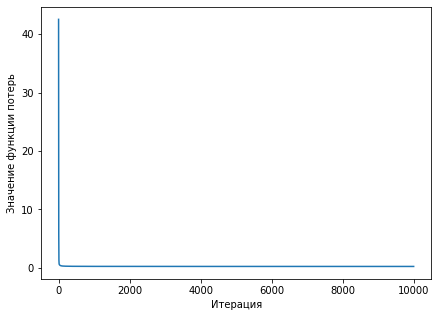

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(comp.loss_history)
ax.set_xlabel('Итерация')
ax.set_ylabel('Значение функции потерь')

plt.show()